In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls,linprog
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
%matplotlib inline

In [7]:
#specify data source 
#datasource = 'L'

In [8]:
#zipcode = '08640'
#zipcode = '08641'
#zipcode = '92562'
#zipcode = '92563'
[datasource, zipcode] = ['Stanford','94305']

In [9]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [10]:
data = pd.read_csv(dataDir +'/training_data_fitted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [11]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,4.050097,0.944918,0.034118,0.370151,0.451887,0.615727,0.651572,0.672137,0.70027,0.582532,0.431649,0.553558,0.054484,2013-01-01,-355,0.492451,True,False,False,4.040561


In [12]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.029872,0.384338,0.45472,0.592189,0.632863,0.674561,0.646563,0.644698,0.48877,0.48436,0.04578


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

In [13]:
shift = 0.01
data['r'] = (data.power+shift)/(data.mpower+shift)

In [14]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r
0,2013-01-01 07:25:00,0.009829,-298.94417,0.005003,1,6000,-1,-355,0.02947,0.380123


Here we number steps from sun rise to sun set. Don't need in for now.

In [15]:
'''
data['StepOfDay'] = float('NaN')
for DateOfInterest in list(dsummary.Date):
    bool_list = d.tsLocal.map(lambda x: x.date() == DateOfInterest)
    indexlist = [i for i, elem in enumerate(bool_list) if elem]
    data['StepOfDay'].loc[indexlist] = range(0,sum(bool_list))
    '''
[0]

[0]

# Adjustment of maximum power envelope

It is worth to look how well maximum power envelope works. Let's look at the histogram and percentile of $r=1.0$

(array([  1.01441000e+05,   7.22400000e+03,   6.41000000e+02,
          3.49000000e+02,   2.05000000e+02,   2.73000000e+02,
          1.76000000e+02,   4.20000000e+01,   2.40000000e+01,
          7.00000000e+00]),
 array([  0.02316124,   1.19206742,   2.36097359,   3.52987977,
          4.69878594,   5.86769212,   7.03659829,   8.20550447,
          9.37441064,  10.54331682,  11.712223  ]),
 <a list of 10 Patch objects>)

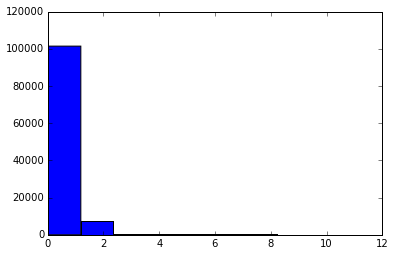

In [16]:
plt.hist(list(data['r'].dropna()))

In [17]:
scipy.stats.percentileofscore(data['r'].dropna(),1.0), np.percentile(data['r'].dropna(),99), np.max(data['r'])

(68.895290898878443, 3.4547629685217234, 11.712222995574901)

Or we can look at absolute difference.

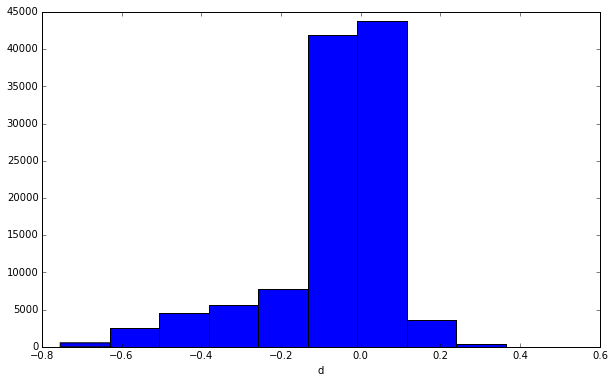

In [18]:

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
ax1.hist(list((data['power']-data['mpower']).dropna()))
ax1.set_xlabel('d')

In [19]:
[scipy.stats.percentileofscore((data['power']-data['mpower']).dropna(),0), np.percentile((data['power']-data['mpower']).dropna(),99),
np.max((data['power']-data['mpower']).dropna())]

[68.895290898878443, 0.20242785884419517, 0.48757118512166769]

To ensure maximum envelope is really maximum, we can shift or scale the maximum power curve.

# Search for optimal shift and scale

We can write shift/scale as an optimization problem.
\begin{equation*}
\begin{aligned}
& \underset{a,b}{\text{minimize}}
& & \sum_{i=1}^{N} [a m_i + b - m_i] \\
& \text{subject to}
& & p_i \leq a m_i + b ; i = 1, \ldots, N,
\end{aligned}
\end{equation*}

where $a$ is scaling factor, $b$ is vertical shift, $m_i$ is a value on original maximum power curves, $p_i$ is a value of normalized power curves, and $N$ is the number of points in all maximum power curves. The optimal solution of such problem is also the optimal solution of 

\begin{equation*}
\begin{aligned}
& \underset{a,b}{\text{minimize}}
& & a \sum_{i=1}^{N} m_i + Nb \\
& \text{subject to}
& & a m_i + b \geq p_i ; i = 1, \ldots, N,
\end{aligned}
\end{equation*}

It turns out that the shift only is the optimal solution, which makes sense because scaling up everything tends to cause more change.

In [20]:
d = data[['power','mpower']].dropna()
d2 = d[d.mpower<d.power] #select only crucial points
coef_1 = np.sum(d['mpower'])
coef_2 = len(d['mpower'])

In [21]:
c = np.array([coef_1, coef_2])

In [22]:
A_ub = np.ones((2,len(d2['mpower'])))#-np.array(data['mpower'],np.ones(coef_2))
A_ub[0] = d2['mpower']
A_ub = -np.transpose(A_ub)

In [23]:
b_ub = np.ones((1,len(d2['mpower'])))
b_ub = -d2['power']

In [24]:
c.shape, A_ub.shape, b_ub.shape 

((2L,), (34334L, 2L), (34334L,))

In [25]:
np.max(d2['power']/d2['mpower']), np.max(d2['power']-d2['mpower'])

(774.9148836528758, 0.48757118512166769)

In [26]:
x0_bounds = (1,np.max(d2['power']/d2['mpower']))
x1_bounds = (0,np.max(d2['power']-d2['mpower']))

In [27]:
result = scipy.optimize.linprog(c, A_ub, b_ub,bounds=(x0_bounds, x1_bounds),\
                                method='simplex', callback=None,\
                                options = {"disp": True,"bland":True, "tol":1e-15})

MemoryError: 

In [ ]:
result

In [ ]:
#Does not work because cvxopt is not properly installed.
'''
from cvxopt import matrix, solvers
A = matrix(A_ub)
b = matrix(b_ub)
c = matrix(c)
sol=solvers.lp(c,A,b)
scipy.optimize.linprog(c, A_ub, b_ub, method='simplex', callback=None, options=None)
'''
[0]

Here is the solution for each dataset. Checked!

08640: [1, 0.1027]

08641: [1, 0.1458]

92562: [1,  0.0862]

92563: [1,  0.0963]

94305: [1, 0.4876]
